In [22]:
import random
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import RootMeanSquaredError
from sklearn.preprocessing import StandardScaler

random.seed(0)
tf.random.set_seed(0)
np.random.seed(0)

In [2]:
train = pd.read_csv("./data/train_preproc_lstm1.csv")

In [3]:
def make_seq_data(train_x, train_y, test_x, test_y, pred_days, seq_len):
    train_x_seq = []
    train_y_seq = []
    test_x_seq = []
    test_y_seq = []
    
    for i in range(seq_len, len(train_x)-pred_days):
        train_x_seq.append(train_x[i - seq_len:i])
        train_y_seq.append(train_y.iloc[i])

    for i in range(seq_len, len(test_x)-pred_days):
        test_x_seq.append(test_x[i - seq_len:i])
        test_y_seq.append(test_y.iloc[i])

    train_x_seq, train_y_seq = np.array(train_x_seq), np.array(train_y_seq)
    test_x_seq, test_y_seq = np.array(test_x_seq), np.array(test_y_seq)

    return train_x_seq, train_y_seq, test_x_seq, test_y_seq

In [25]:
import matplotlib.pyplot as plt

class lstm_model():
    def __init__(self, input_shape, learning_rate=1e-2, loss='mse', load_path=None):
        
        model = Sequential()
        model.add(LSTM(256, input_shape=input_shape, return_sequences=True))
        model.add(LSTM(128, return_sequences=True))
        model.add(LSTM(32, return_sequences=True))
        model.add(Flatten())
        model.add(Dense(1))
        self.model = model
        self.optimizer = Adam(learning_rate=learning_rate)
        
        if load_path is not None:
            self.load_model(load_path)

        self.model.compile(optimizer=self.optimizer, loss=loss)
    
    def save_model(self, path):
        self.model.save_weights(path)
    
    def load_model(self, path):
        self.model.load_weights(path)

    # 학습 후 loss 그래프 그림
    def train(self, train_x, train_y, epochs=100, batch_size=32, validation_split=0.1):
        history = self.model.fit(train_x, train_y,
                                 epochs=epochs,
                                 batch_size=batch_size,
                                 validation_split=validation_split)
        plt.figure(figsize=(7, 3))
        plt.plot(history.history['loss'], label='Training loss')
        plt.plot(history.history['val_loss'], label='Validation loss')
        plt.legend()
        plt.show()

        self.history = history

    def predict(self, x, y):
        pred = self.model.predict(x)
        rmse = RootMeanSquaredError()
        print(rmse(y, pred))

        return pred
    
    def plot_pred(self, y, pred_y, title=None):
        plt.figure(figsize=(20, 3))
        plt.plot(y, label='GT')
        plt.plot(pred_y, label='prediction')
        plt.title(title)
        plt.legend()
        plt.show()

    def pred_plot(self, x, y, title=None):
        pred = self.predict(x, y)
        self.plot_pred(y, pred, title)

In [12]:
model_dic = {}
pred_days = 1
seq_len = 14

seq_dict = {}

for i in tqdm(train.item.unique()):
    train_x_seq = np.empty([0, 14, 16])
    train_y_seq = np.empty([0])
    test_x_seq = np.empty([0, 14, 16])
    test_y_seq = np.empty([0])

    print(f"Make sequence data for {i}...")
    for co in train.corporation.unique():
        for lo in train.location.unique():
            train_now = train.loc[train.item == i]
            x = train_now.drop(['item', 'corporation', 'location'], axis=1)
            y = train_now['price']

            n_train = int(len(x) * 0.9)

            scaler = StandardScaler()
            x = scaler.fit_transform(x)
            
            train_x, test_x = x[:n_train], x[n_train:]
            train_y, test_y = y[:n_train], y[n_train:]

            seq_data = make_seq_data(train_x, train_y, test_x, test_y, pred_days, seq_len)
            train_x_seq = np.concatenate((train_x_seq, seq_data[0]), axis=0)
            train_y_seq = np.concatenate((train_y_seq, seq_data[1]), axis=0)
            test_x_seq = np.concatenate((test_x_seq, seq_data[2]), axis=0)
            test_y_seq = np.concatenate((test_y_seq, seq_data[3]), axis=0)

    print("Done")

    seq_dict[i] = [train_x_seq, train_y_seq, test_x_seq, test_y_seq, scaler]

  0%|          | 0/5 [00:00<?, ?it/s]

Make sequence data for TG...
Done
Make sequence data for CR...
Done
Make sequence data for CB...
Done
Make sequence data for RD...
Done
Make sequence data for BC...
Done


  0%|          | 0/5 [00:00<?, ?it/s]

Train LSTM with TG data...
Epoch 1/10
4622/4622 [==============================] - 141s 29ms/step - loss: 2592.8711 - val_loss: 2078.8508
Epoch 2/10
4622/4622 [==============================] - 131s 28ms/step - loss: 1853.1602 - val_loss: 1557.2618
Epoch 3/10
4622/4622 [==============================] - 132s 29ms/step - loss: 1315.4906 - val_loss: 1095.2999
Epoch 4/10
4622/4622 [==============================] - 132s 28ms/step - loss: 960.2917 - val_loss: 876.4012
Epoch 5/10
4622/4622 [==============================] - 132s 29ms/step - loss: 817.6570 - val_loss: 763.2303
Epoch 6/10
4622/4622 [==============================] - 132s 29ms/step - loss: 732.7054 - val_loss: 703.2649
Epoch 7/10
4622/4622 [==============================] - 132s 29ms/step - loss: 667.6033 - val_loss: 628.1591
Epoch 8/10
4622/4622 [==============================] - 131s 28ms/step - loss: 608.6678 - val_loss: 572.6006
Epoch 9/10
4622/4622 [==============================] - 132s 29ms/step - loss: 559.0972 - val_l

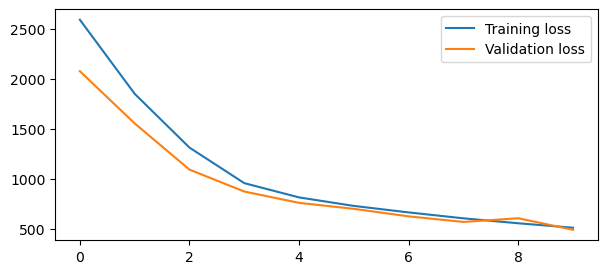

566/566 [==============================] - 8s 12ms/step
tf.Tensor(1381.7518, shape=(), dtype=float32)


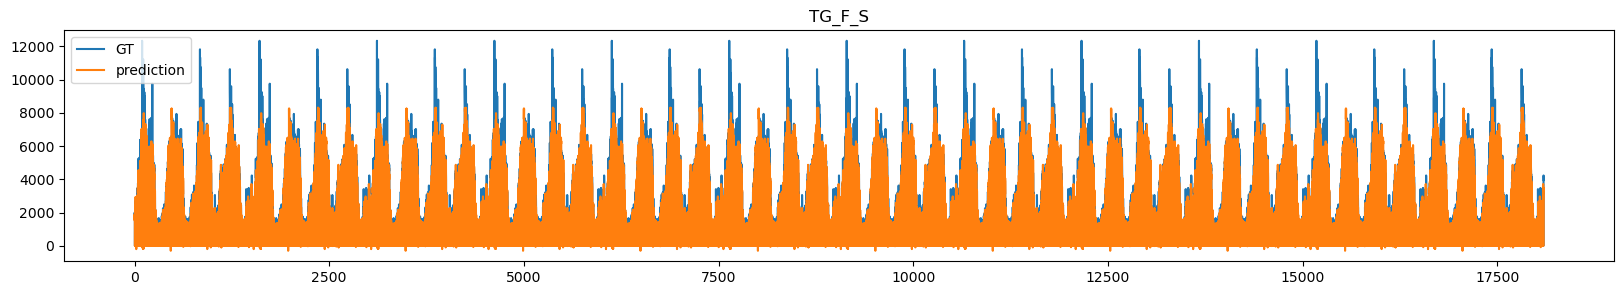

Train LSTM with CR data...
Epoch 1/10
3233/3233 [==============================] - 115s 34ms/step - loss: 245.4746 - val_loss: 212.3911
Epoch 2/10
3233/3233 [==============================] - 100s 31ms/step - loss: 198.2376 - val_loss: 180.7940
Epoch 3/10
3233/3233 [==============================] - 101s 31ms/step - loss: 181.2588 - val_loss: 164.7083
Epoch 4/10
3233/3233 [==============================] - 97s 30ms/step - loss: 167.0592 - val_loss: 148.0958
Epoch 5/10
3233/3233 [==============================] - 100s 31ms/step - loss: 148.0205 - val_loss: 134.5342
Epoch 6/10
3233/3233 [==============================] - 98s 30ms/step - loss: 129.0216 - val_loss: 112.0769
Epoch 7/10
3233/3233 [==============================] - 99s 31ms/step - loss: 113.2562 - val_loss: 94.2734
Epoch 8/10
3233/3233 [==============================] - 100s 31ms/step - loss: 94.0284 - val_loss: 88.5007
Epoch 9/10
3233/3233 [==============================] - 96s 30ms/step - loss: 82.0230 - val_loss: 74.2488
E

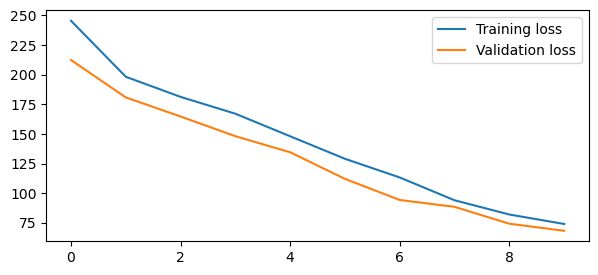

395/395 [==============================] - 7s 13ms/step
tf.Tensor(90.49757, shape=(), dtype=float32)


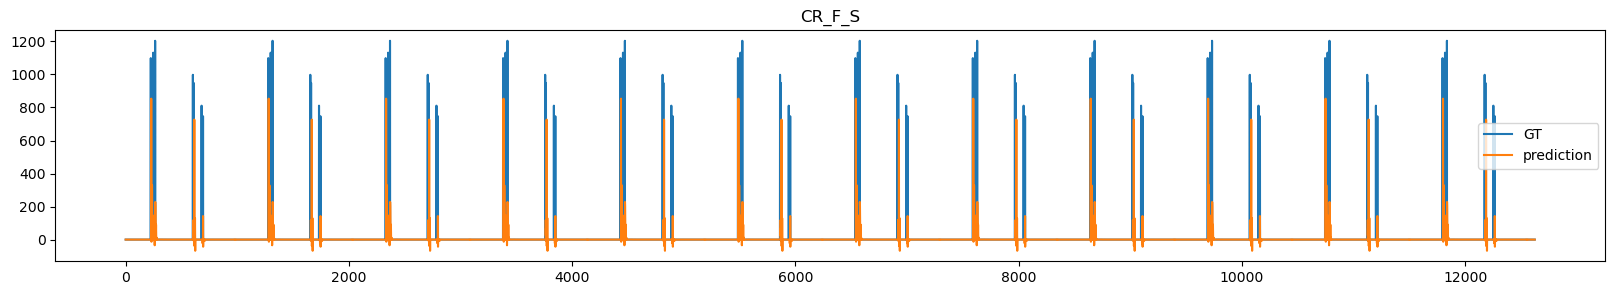

Train LSTM with CB data...
Epoch 1/10
2308/2308 [==============================] - 75s 30ms/step - loss: 124.7902 - val_loss: 123.9555
Epoch 2/10
2308/2308 [==============================] - 72s 31ms/step - loss: 108.4366 - val_loss: 103.8700
Epoch 3/10
2308/2308 [==============================] - 70s 30ms/step - loss: 88.7691 - val_loss: 82.3608
Epoch 4/10
2308/2308 [==============================] - 67s 29ms/step - loss: 74.0125 - val_loss: 71.7341
Epoch 5/10
2308/2308 [==============================] - 67s 29ms/step - loss: 66.5284 - val_loss: 62.7617
Epoch 6/10
2308/2308 [==============================] - 67s 29ms/step - loss: 58.2704 - val_loss: 56.7422
Epoch 7/10
2308/2308 [==============================] - 67s 29ms/step - loss: 50.5443 - val_loss: 51.2266
Epoch 8/10
2308/2308 [==============================] - 70s 30ms/step - loss: 44.0836 - val_loss: 48.0179
Epoch 9/10
2308/2308 [==============================] - 69s 30ms/step - loss: 40.5025 - val_loss: 37.5521
Epoch 10/10
230

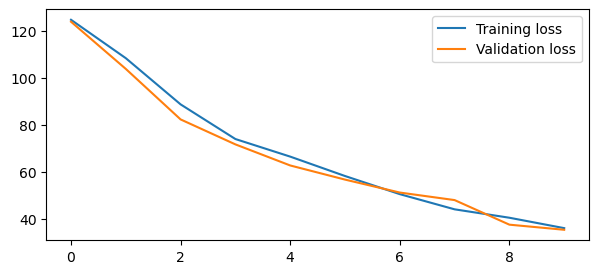

281/281 [==============================] - 5s 13ms/step
tf.Tensor(239.31374, shape=(), dtype=float32)


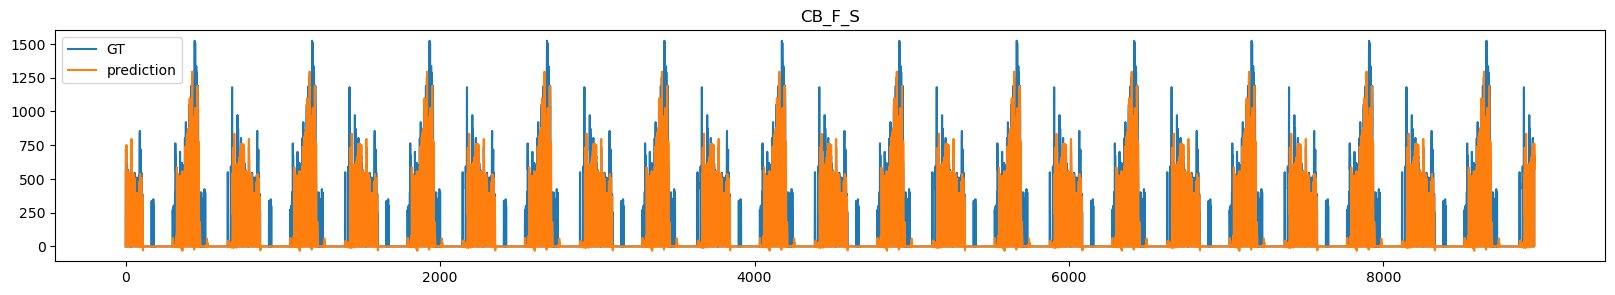

Train LSTM with RD data...
Epoch 1/10
3696/3696 [==============================] - 119s 31ms/step - loss: 114.5239 - val_loss: 100.9558
Epoch 2/10
3696/3696 [==============================] - 111s 30ms/step - loss: 98.9615 - val_loss: 89.6502
Epoch 3/10
3696/3696 [==============================] - 111s 30ms/step - loss: 86.1353 - val_loss: 77.0604
Epoch 4/10
3696/3696 [==============================] - 114s 31ms/step - loss: 75.6959 - val_loss: 68.1641
Epoch 5/10
3696/3696 [==============================] - 111s 30ms/step - loss: 64.8319 - val_loss: 62.9119
Epoch 6/10
3696/3696 [==============================] - 121s 33ms/step - loss: 57.7259 - val_loss: 51.6723
Epoch 7/10
3696/3696 [==============================] - 116s 31ms/step - loss: 50.4932 - val_loss: 46.2008
Epoch 8/10
3696/3696 [==============================] - 115s 31ms/step - loss: 45.2576 - val_loss: 41.8857
Epoch 9/10
3696/3696 [==============================] - 119s 32ms/step - loss: 39.9666 - val_loss: 36.2764
Epoch 10

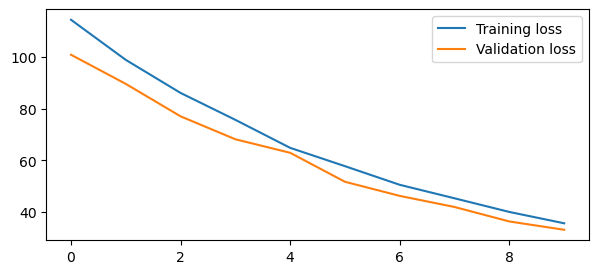

452/452 [==============================] - 7s 13ms/step
tf.Tensor(186.44711, shape=(), dtype=float32)


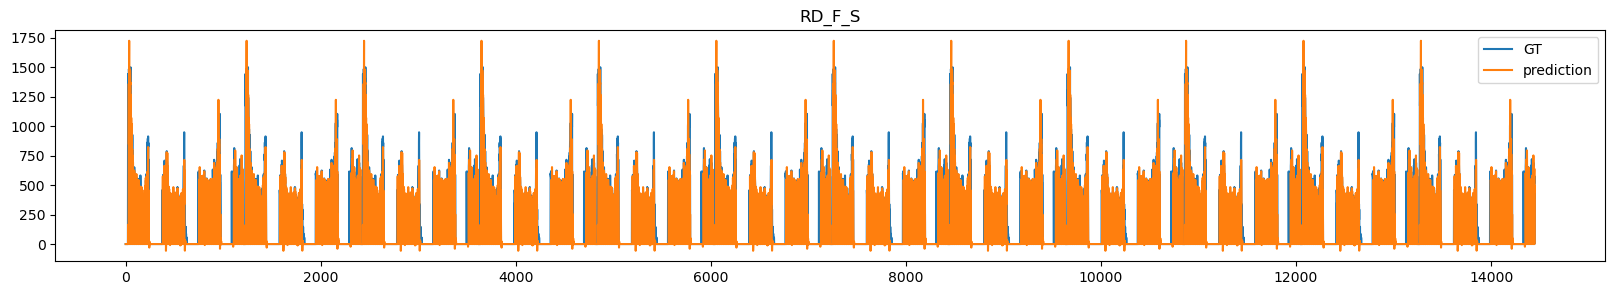

Train LSTM with BC data...
Epoch 1/10
4159/4159 [==============================] - 130s 30ms/step - loss: 687.3030 - val_loss: 544.7297
Epoch 2/10
4159/4159 [==============================] - 124s 30ms/step - loss: 434.3252 - val_loss: 442.8230
Epoch 3/10
4159/4159 [==============================] - 124s 30ms/step - loss: 321.1596 - val_loss: 283.0460
Epoch 4/10
4159/4159 [==============================] - 125s 30ms/step - loss: 250.8941 - val_loss: 244.9952
Epoch 5/10
4159/4159 [==============================] - 133s 32ms/step - loss: 220.3970 - val_loss: 204.9480
Epoch 6/10
4159/4159 [==============================] - 130s 31ms/step - loss: 190.3044 - val_loss: 184.6305
Epoch 7/10
4159/4159 [==============================] - 130s 31ms/step - loss: 167.5591 - val_loss: 158.9480
Epoch 8/10
4159/4159 [==============================] - 130s 31ms/step - loss: 143.9231 - val_loss: 137.4446
Epoch 9/10
4159/4159 [==============================] - 130s 31ms/step - loss: 129.2375 - val_loss: 1

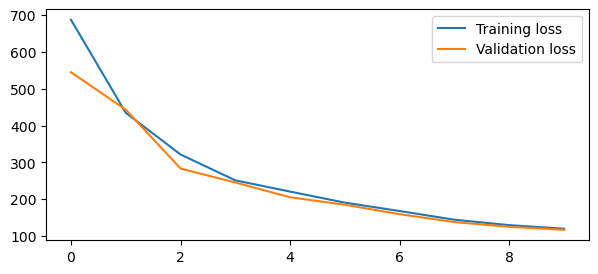

509/509 [==============================] - 10s 17ms/step
tf.Tensor(728.5947, shape=(), dtype=float32)


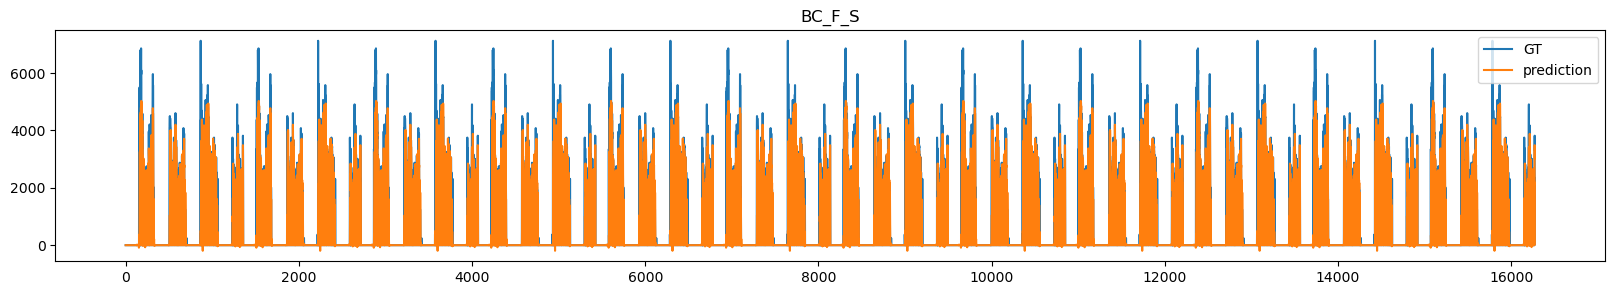

In [28]:
epochs = 10
batch_size = 32
learning_rate = 1e-3
loss = 'mean_absolute_error'

for i in tqdm(train.item.unique()):
    
    lstm = lstm_model((seq_len, 16),
                      learning_rate=learning_rate,
                      loss=loss)
    
    train_x_seq, train_y_seq, test_x_seq, test_y_seq, _ = seq_dict[i]

    print(f"Train LSTM with {i} data...")
    lstm.train(train_x_seq, train_y_seq,
            epochs=epochs,
            batch_size=batch_size)
    lstm.pred_plot(test_x_seq, test_y_seq, f'{i}_{co}_{lo}')

    model_dic[i] = (lstm, scaler)

In [31]:
for i in model_dic:
    model_dic[i][0].save_model(f'./lstm/{i}_model/lstm')

In [53]:
lstm.predict(train_x_seq)

4406/4406 [==============================] - 15s 3ms/step


array([[3691.1733],
       [3691.1733],
       [3691.1733],
       ...,
       [3691.1733],
       [3691.1733],
       [3691.1733]], dtype=float32)